In [1]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LinearRegression,
    LogisticRegression,
    Trainer
)

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [2]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 25
SIZE = 200
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
X = torch.randn(SIZE, 2, dtype=DTYPE, device='cpu')
y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + .3 * torch.randn(SIZE, dtype=DTYPE, device='cpu')

In [ ]:
# Targets for Logistic Regression
probs = torch.sigmoid(y)
print(f"Probabilities:\n{probs}")

In [ ]:
y = (probs > .98).float()
print(f"Targets for logistic regression task:\n{y}")

In [ ]:
# Frequency of labels
print(f"# of Targets (0 and 1):" , "-> 0: {}".format(y[y == 0].numel()), "-> 1: {}".format(y[y == 1].numel()), sep="\n")

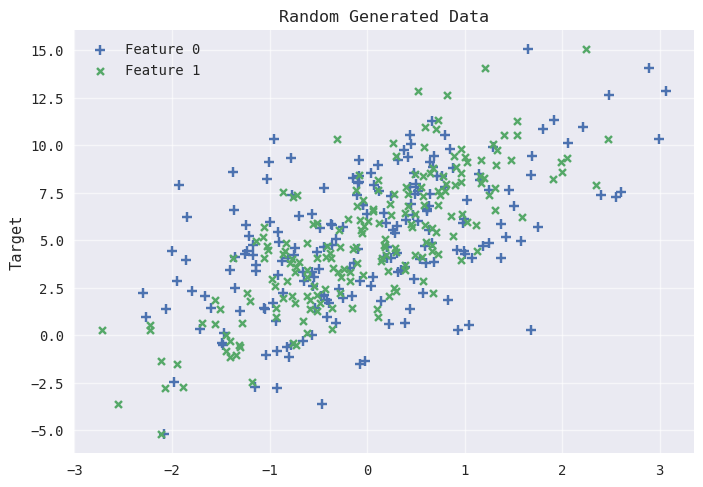

In [7]:
plt.scatter(X[:, 0].numpy(), y.numpy(), marker='+', label="Feature 0", s=50);
plt.scatter(X[:, 1].numpy(), y.numpy(), marker='x', label="Feature 1", s=25);
# plt.plot(
#     torch.sigmoid(torch.linspace(y.min(), y.max(), SIZE))
# )
plt.grid(True, alpha = .6);
plt.title("Random Generated Data");
plt.ylabel("Target");
plt.legend(loc='best');
plt.show()

In [8]:
X, X.shape

(tensor([[ 4.8526e-01,  6.4511e-01],
         [-2.2978e+00,  6.7921e-01],
         [ 2.0614e-01, -1.1274e-01],
         [ 2.9956e-03,  4.9564e-01],
         [ 6.6984e-01,  1.5337e+00],
         [-8.6287e-01, -2.7947e-01],
         [ 1.6475e+00,  2.2415e+00],
         [ 4.1606e-02,  9.6518e-01],
         [-1.3584e+00,  5.6489e-01],
         [-5.6351e-01,  9.7220e-01],
         [ 1.1477e+00,  4.9377e-01],
         [ 6.6916e-01, -6.1301e-01],
         [ 4.2419e-01,  1.0011e+00],
         [-1.9467e+00,  5.7350e-01],
         [-6.4906e-01, -1.7591e-01],
         [-3.8507e-01, -7.3417e-01],
         [ 9.2596e-01, -1.0115e+00],
         [-1.7111e+00, -3.5535e-01],
         [ 2.5561e+00, -7.6310e-01],
         [ 3.5295e-01, -6.1366e-01],
         [ 2.5038e-01, -3.6903e-01],
         [ 5.2155e-01,  1.3968e-02],
         [ 5.3937e-01, -7.6854e-01],
         [-5.3731e-01, -9.2843e-01],
         [-4.0932e-02,  7.2802e-01],
         [-6.8965e-02, -1.9466e+00],
         [ 9.8728e-01, -5.1372e-01],
 

In [9]:
y, y.shape

(tensor([ 8.5304e+00,  2.2467e+00,  4.6458e+00,  6.3617e+00,  1.1283e+01,
          2.2268e+00,  1.5056e+01,  8.5111e+00,  4.1228e+00,  6.3988e+00,
          8.4909e+00,  4.8354e+00,  9.3547e+00,  2.8662e+00,  2.8712e+00,
          1.7186e+00,  4.4947e+00,  3.3568e-01,  7.2718e+00,  3.4411e+00,
          4.0701e+00,  6.0076e+00,  3.9915e+00,  1.4127e+00,  6.8309e+00,
         -1.5030e+00,  5.9036e+00,  8.2005e+00,  4.5800e+00, -1.0171e+00,
          2.4650e+00,  7.3900e+00,  1.6722e+00,  4.9672e+00,  6.7862e+00,
          7.7660e+00,  4.6880e+00,  4.2899e+00,  1.4083e+00,  4.8287e+00,
          3.8562e+00,  5.6578e+00,  4.4045e+00, -3.1867e-01, -6.0972e-01,
          5.8464e+00,  3.5975e+00,  2.2212e+00,  6.6450e+00,  8.3860e+00,
          9.0889e+00,  3.9415e+00,  9.7917e+00,  2.0804e+00,  6.0454e+00,
          5.7635e+00,  2.7475e-01,  5.1985e+00,  1.4132e+00,  4.2475e+00,
          5.3749e-01,  5.9037e+00, -2.7361e+00, -2.7962e+00,  3.1854e+00,
          1.2837e+01,  4.0691e+00,  1.

In [10]:
Data = TensorDataset(X, y)
Data.tensors

(tensor([[ 4.8526e-01,  6.4511e-01],
         [-2.2978e+00,  6.7921e-01],
         [ 2.0614e-01, -1.1274e-01],
         [ 2.9956e-03,  4.9564e-01],
         [ 6.6984e-01,  1.5337e+00],
         [-8.6287e-01, -2.7947e-01],
         [ 1.6475e+00,  2.2415e+00],
         [ 4.1606e-02,  9.6518e-01],
         [-1.3584e+00,  5.6489e-01],
         [-5.6351e-01,  9.7220e-01],
         [ 1.1477e+00,  4.9377e-01],
         [ 6.6916e-01, -6.1301e-01],
         [ 4.2419e-01,  1.0011e+00],
         [-1.9467e+00,  5.7350e-01],
         [-6.4906e-01, -1.7591e-01],
         [-3.8507e-01, -7.3417e-01],
         [ 9.2596e-01, -1.0115e+00],
         [-1.7111e+00, -3.5535e-01],
         [ 2.5561e+00, -7.6310e-01],
         [ 3.5295e-01, -6.1366e-01],
         [ 2.5038e-01, -3.6903e-01],
         [ 5.2155e-01,  1.3968e-02],
         [ 5.3937e-01, -7.6854e-01],
         [-5.3731e-01, -9.2843e-01],
         [-4.0932e-02,  7.2802e-01],
         [-6.8965e-02, -1.9466e+00],
         [ 9.8728e-01, -5.1372e-01],
 

In [11]:
Model = LinearRegression(in_dims=2).to(DEVICE)

In [12]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.L1Loss(reduction='mean'),
    device=DEVICE
)

In [14]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([1.9962, 0.7990], device='cuda:0')
	Epoch 1 | Bias: tensor([1.0156], device='cuda:0')
	Epoch 1 | Weights: tensor([2.0311, 0.8023], device='cuda:0')
	Epoch 1 | Bias: tensor([1.1156], device='cuda:0')
	Epoch 1 | Weights: tensor([2.0258, 0.8596], device='cuda:0')
	Epoch 1 | Bias: tensor([1.2031], device='cuda:0')
	Epoch 1 | Weights: tensor([2.0138, 0.8522], device='cuda:0')
	Epoch 1 | Bias: tensor([1.2906], device='cuda:0')
	Epoch 1 | Weights: tensor([2.0094, 0.8847], device='cuda:0')
	Epoch 1 | Bias: tensor([1.3844], device='cuda:0')
Epoch 1/25 | Loss: 3.9501
	| Validation Loss: 3.4697

	Epoch 2 | Weights: tensor([1.9933, 0.9228], device='cuda:0')
	Epoch 2 | Bias: tensor([1.4719], device='cuda:0')
	Epoch 2 | Weights: tensor([2.0105, 0.9346], device='cuda:0')
	Epoch 2 | Bias: tensor([1.5594], device='cuda:0')
	Epoch 2 | Weights: tensor([2.0281, 0.9443], device='cuda:0')
	Epoch 2 | Bias: tensor([1.6594], device='cuda:0')
	Epoch 2 | Weights: tensor([1.9997, 0.9785

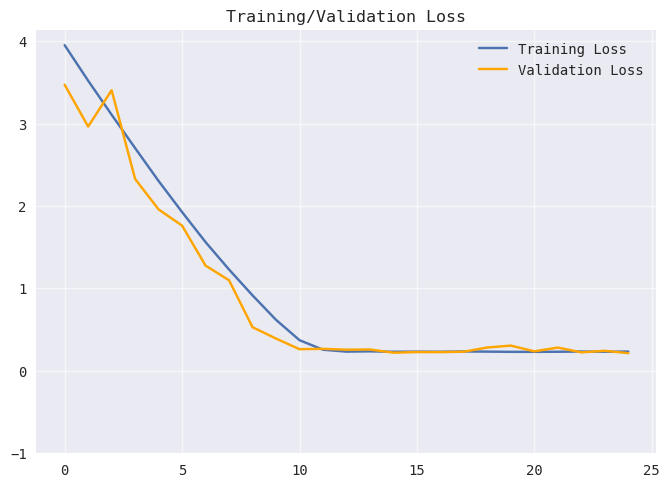

In [15]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.ylim(bottom=-1)
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [16]:
# y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + torch.randn(SIZE, dtype=DTYPE, device='cpu')
print(
    f"Trained Weights: {Model.w.data}",
    f"Trained Bias: {Model.b.data}",
    sep="\n"
)

Trained Weights: tensor([2.0286, 3.0127], device='cuda:0')
Trained Bias: tensor([4.9969], device='cuda:0')


In [17]:
# Analytical Solution
# First, bias must be added to the design matrix
X = torch.tensor(np.concatenate([X, np.ones((SIZE, 1))], axis=1), dtype=DTYPE, device='cpu')

w = torch.linalg.inv(X.T @ X) @ X.T @ y
print(f"Analytical Solution for Weights: {w}")

Analytical Solution for Weights: tensor([2.0152, 2.9844, 4.9953])


In [18]:
T = np.linspace(X.min(), X.max(), SIZE, dtype=np.float32).reshape(SIZE, 1)
T = torch.tensor(np.concatenate([T, T], axis=1), device=DEVICE)

# Inference
Model.eval()
with torch.no_grad():
    yT = Model(T)

print(f"\nGenerated T:\n{T}")
print(f"\nPredictions:\n{yT}")


Generated T:
tensor([[-2.7184, -2.7184],
        [-2.6893, -2.6893],
        [-2.6603, -2.6603],
        [-2.6312, -2.6312],
        [-2.6022, -2.6022],
        [-2.5731, -2.5731],
        [-2.5441, -2.5441],
        [-2.5150, -2.5150],
        [-2.4860, -2.4860],
        [-2.4569, -2.4569],
        [-2.4279, -2.4279],
        [-2.3988, -2.3988],
        [-2.3698, -2.3698],
        [-2.3408, -2.3408],
        [-2.3117, -2.3117],
        [-2.2827, -2.2827],
        [-2.2536, -2.2536],
        [-2.2246, -2.2246],
        [-2.1955, -2.1955],
        [-2.1665, -2.1665],
        [-2.1374, -2.1374],
        [-2.1084, -2.1084],
        [-2.0793, -2.0793],
        [-2.0503, -2.0503],
        [-2.0212, -2.0212],
        [-1.9922, -1.9922],
        [-1.9631, -1.9631],
        [-1.9341, -1.9341],
        [-1.9050, -1.9050],
        [-1.8760, -1.8760],
        [-1.8469, -1.8469],
        [-1.8179, -1.8179],
        [-1.7888, -1.7888],
        [-1.7598, -1.7598],
        [-1.7307, -1.7307],
      

In [19]:
T.shape, yT.shape

(torch.Size([200, 2]), torch.Size([200]))

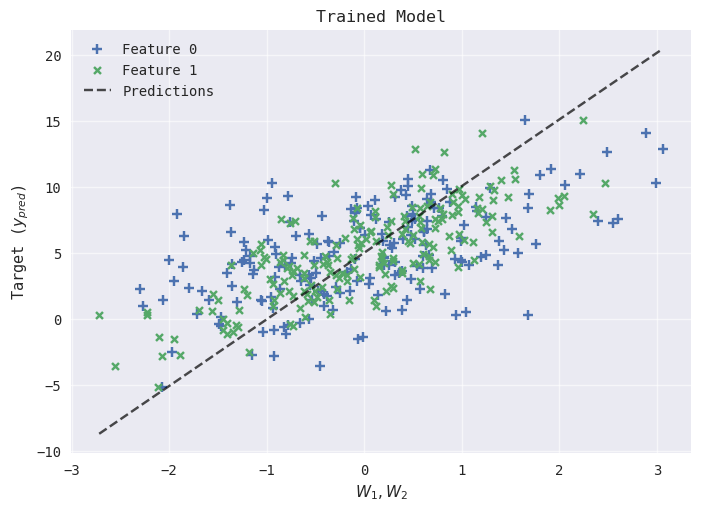

In [20]:
plt.scatter(X[:, 0].numpy(), y.numpy(), marker='+', label="Feature 0", s=50);
plt.scatter(X[:, 1].numpy(), y.numpy(), marker='x', label="Feature 1", s=25);
# Predicted Linear Model
plt.plot(T[:, 0].cpu().numpy(), yT.cpu().numpy(), color="black", alpha=.7, linestyle='--', label="Predictions");
plt.grid(True, alpha = .6);
plt.title("Trained Model");
plt.xlabel("$W_1, W_2$");
plt.ylabel("Target ($y_{pred}$)");
plt.legend(loc='best');
plt.show()